In [41]:
%%capture
pip install 'opendp[polars]'

# Explore opendp==0.14
https://docs.opendp.org/en/stable/getting-started/quickstart.html

In [42]:
import opendp.prelude as dp
import polars as pl

dp.enable_features("contrib")

In [43]:
PATH = "penguin.csv"

In [44]:
lf = pl.scan_csv(PATH, ignore_errors=True)
lf

In [45]:
df = lf.collect()
print(df.shape[0])
df.head(2)

344


species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
str,str,f64,f64,f64,f64,str
"""Adelie""","""Torgersen""",39.1,18.7,181.0,3750.0,"""MALE"""
"""Adelie""","""Torgersen""",39.5,17.4,186.0,3800.0,"""FEMALE"""


# LINEAR REGRESSION

In [46]:
import matplotlib.pyplot as plt
import numpy as np

In [47]:
dp.enable_features("floating-point", "contrib", "honest-but-curious")

In [48]:
lin_reg = dp.sklearn.linear_model.LinearRegression(
    dp.max_divergence(),
    x_bounds=[(13.0, 23.0)],
    y_bounds=(30.0, 65.0),
    scale=1,
)

In [49]:
df = lf.drop_nulls(["bill_depth_mm", "bill_length_mm", "flipper_length_mm", "body_mass_g"]).collect()
print(df.shape[0])
X = df["bill_depth_mm"].to_numpy().reshape(-1, 1) 
y = df["bill_length_mm"].to_numpy()

342


In [50]:
lin_reg = lin_reg.fit(X=X, y=y)

/opt/python/lib/python3.13/site-packages/opendp/extras/sklearn/linear_model/_make_private_theil_sen/__init__.py:30: RuntimeWarning: divide by zero encountered in divide
  points = dy / dx * (x_cuts[None].T - x_bar) + y_bar


In [51]:
lin_reg.score(X,y)

0.025721415908392165

In [52]:
lin_reg.intercept_, lin_reg.coef_

(np.float64(55.77272727272727), array([-0.63636364]))

In [53]:
x_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred = lin_reg.predict(x_line)

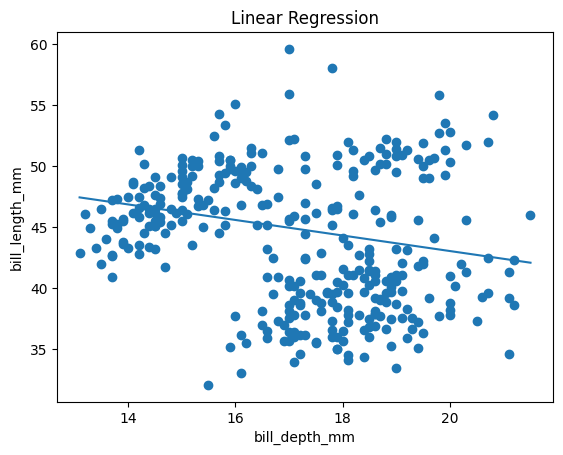

In [54]:
plt.title("Linear Regression")
plt.scatter(X, y)
plt.plot(x_line, y_pred)
plt.xlabel("bill_depth_mm")
plt.ylabel("bill_length_mm")
plt.show()

# SYNTHETIC DATASET

In [55]:
%%capture
!pip install 'opendp[mbi]'

In [56]:
context = dp.Context.compositor(
    data=lf,
    privacy_unit=dp.unit_of(contributions=36),
    privacy_loss=dp.loss_of(rho=0.19, delta=1e-7),
)

In [57]:
table_aim = (
    context.query(rho=0.1, delta=0.0)
    .select(
        "sex", "species", "island", 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm'
    ).contingency_table(
        keys={
            "sex": ["MALE", "FEMALE"],
            "species": ['Adelie', 'Chinstrap', 'Gentoo'],
            "island": ['Dream', 'Torgersen', 'Biscoe']
        },
        cuts={
            "bill_length_mm": [30, 42, 54, 65], 
            'bill_depth_mm': [13, 18, 23], 
            'flipper_length_mm': [150, 200, 250]
        },
        algorithm=dp.mbi.AIM(),
    )
    .release()
)

In [58]:
table_aim.synthesize(rows=100)

sex,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm
str,str,str,f64,f64,f64
"""FEMALE""",null,null,63.995012,16.695289,149.46201
"""FEMALE""",null,null,43.935568,12.631573,149.803385
"""FEMALE""",null,null,29.9425,19.322095,149.818034
"""FEMALE""",null,null,43.634525,12.647804,149.8042
"""MALE""",null,null,29.303395,18.859316,149.025305
…,…,…,…,…,…
"""FEMALE""",null,"""Torgersen""",29.328932,12.720692,149.053412
"""FEMALE""",null,"""Dream""",57.294932,17.530288,149.352011
"""FEMALE""",null,"""Torgersen""",29.3561,12.14968,149.057806


# PCA

In [75]:
features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]

In [76]:
model = dp.sklearn.decomposition.PCA(
    epsilon=1.0,
    row_norm=1.0,
    n_samples=df.shape[0],
    n_features=len(features),
    n_components=2
)

In [77]:
model.fit(df[features].to_numpy())

,epsilon,1.0
,row_norm,1.0
,n_samples,342
,n_features,4
,n_components,2
,n_changes,1
,whiten,False


In [78]:
print(model.singular_values_)
print(model.components_)

[18.58328093  2.87766121]
[[-0.03594286 -0.10922335 -0.11952781 -0.98614982]
 [-0.36378722 -0.21585705 -0.89435692  0.14556886]]
